## This cell is used to add the parent directory to the path so that the modules can be imported in the notebook. Run this cell only once


In [1]:
import os
import sys
os.chdir('..')

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from scripts.preprocessing import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# ***This cells does not need to be run again as the results are saved in the csv file***

In [3]:
# this cells does not need to be run again as the results are saved in the csv file
# data = pd.read_csv('data/tripadvisor_hotel_reviews.csv')
# data["cleaned_text"] = pipeline.transform(data["Review"].values)
# data.to_csv("data/cleaned_tripadvisor_reviews.csv", index=False)

# ***Creation of a simple class to run our model again and again in an easy way***

In [4]:
class TextClassifier:
    
    def __init__(self, model=None, vectorizer=None, class_weight=None):
        self.model = model 
        self.vectorizer = vectorizer 
        self.X_train_tf = None
        self.X_test_tf = None
        
    def train(self, X_train, y_train):
        # Vectoriser les données d'entraînement
        self.X_train_tf = self.vectorizer.fit_transform(X_train)
        # Entraîner le modèle
        self.model.fit(self.X_train_tf, y_train)
        
    def evaluate(self, X_test, y_test):
        # Transformer les données de test en utilisant le vectoriseur
        self.X_test_tf = self.vectorizer.transform(X_test)
        
        # Prédire et évaluer
        y_pred = self.model.predict(self.X_test_tf)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        print(f"Accuracy: {acc}")
        print(report)
        
        return acc, report
    
    def predict(self, text):
        text_tf = self.vectorizer.transform([text])
        return self.model.predict(text_tf)[0]


# ***First Model (Logistic Regression)***

I chose to use a logistic regression model as a first model because it is a simple model that is easy to interpret and fast. 

In [6]:
dataset = pd.read_csv('data/cleaned_tripadvisor_reviews.csv', index_col=0)

X = dataset['cleaned_text']
y = dataset['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


classifier = TextClassifier(model=LogisticRegression(max_iter=1000), vectorizer=TfidfVectorizer(max_features=5000, stop_words='english'))
classifier.train(X_train, y_train)
classifier.evaluate(X_test, y_test)

Accuracy: 0.6299097340814833
              precision    recall  f1-score   support

           1       0.75      0.62      0.68       292
           2       0.45      0.38      0.41       333
           3       0.44      0.25      0.32       432
           4       0.55      0.50      0.53      1252
           5       0.70      0.86      0.77      1790

    accuracy                           0.63      4099
   macro avg       0.58      0.52      0.54      4099
weighted avg       0.61      0.63      0.61      4099



(0.6299097340814833,
 '              precision    recall  f1-score   support\n\n           1       0.75      0.62      0.68       292\n           2       0.45      0.38      0.41       333\n           3       0.44      0.25      0.32       432\n           4       0.55      0.50      0.53      1252\n           5       0.70      0.86      0.77      1790\n\n    accuracy                           0.63      4099\n   macro avg       0.58      0.52      0.54      4099\nweighted avg       0.61      0.63      0.61      4099\n')

First of all, we have an accuracy of 63% so it means that 63% of the predictions we made were correct. It is not a really good score but maybe the complexity of the datas and the amount of datas we have are not enough to have a better score. we cannot really judge the model only on this actually.

An important thing to notice is the fact that the recall on the class 2 and 3 are really low. it means that the model is not able to differenciate 5 class. It is mainly classifying the datas in the most represented class as for exemple the class 5 has a high recall score what means that most of the 5 are classified as 5 but the precision is 70% so it meas that the model classified a lot as 5 but has a lot of false positive as well. It's a big sign of underfitting: the model can't classify the datas in class 2 or 3 so it just put them in the class that has the highest probability to be the right one.

the low recall of the class 2 and 3 confirm our thought as it show that only 25% of the class 3 are classified as class 3 (more over the precision is 0.44 so the model is not only forgetting the class 3 but also classify badly the small amount of datas that it classify there)

What we want to do is to try to improve the recall of the class 2 and 3. We will focus on this on the next notebook even if improving the accuracy to would be recommended

NB: despite the fact that class 1 contains a small amount of datas the model manage them quite well. this class has probably really specific caracteristics that make it easy to classify.

Text(120.72222222222221, 0.5, 'True Labels')

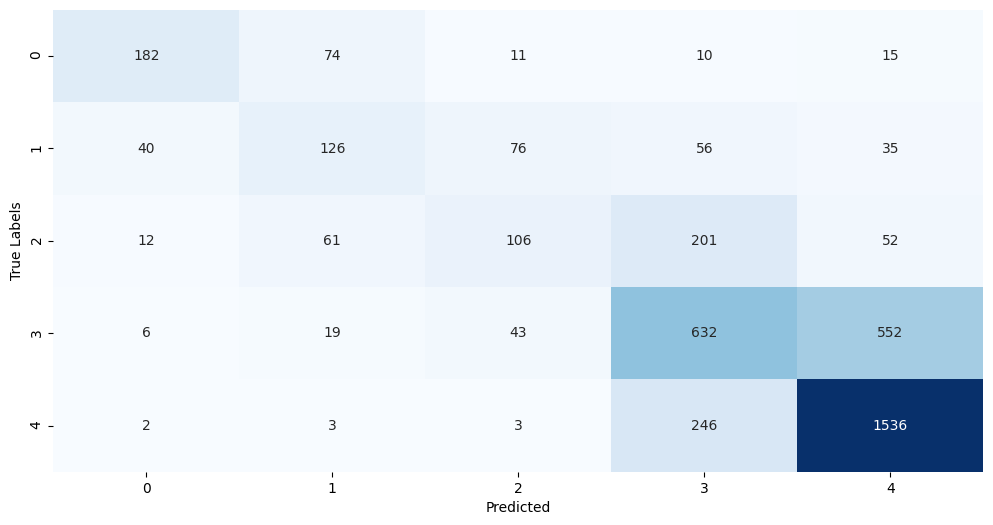

In [16]:
y_pred = classifier.model.predict(classifier.X_test_tf)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True Labels')

### This matrix is difficult to read 

I will normalize the matrix to have a better view of the results with the color of the matrix

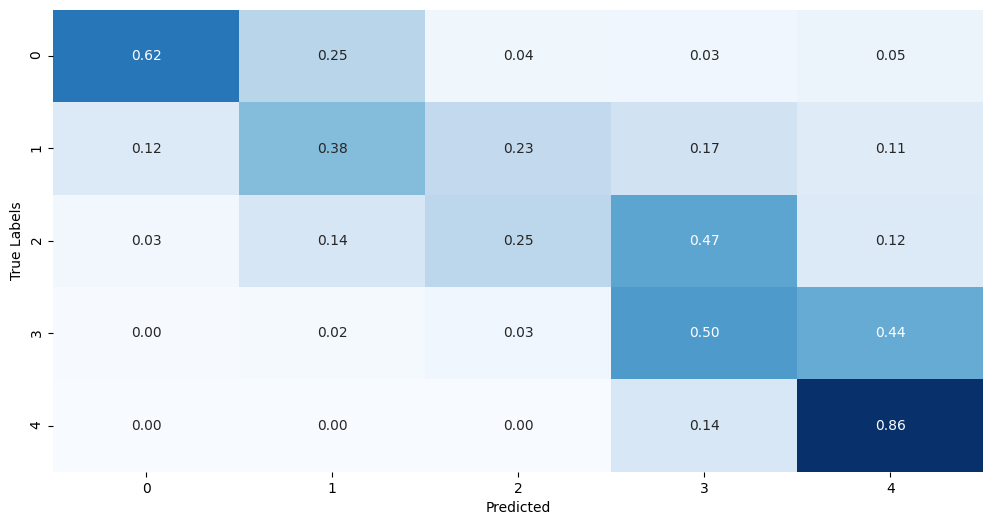

In [22]:
y_pred = classifier.model.predict(classifier.X_test_tf)
cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', cbar=False, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('True Labels')
plt.show()

## ***Analyzing the Confusion Matrix***

- The model tends to confuse similar classes, such as 1 with 2, 2 with 3, 3 with 4, ...
- The model is not doing big mistakes as confusing 1 and 5 or 2 and 5.
- If we decided to combine class 1,2,3 and consider them as "bad review" we will have approximately the same amount of review in the 3 classes but we know that the model will struggle to differenciate bad and 4 as 3 and 4 are the most confused classes.

